# HW2

HW2 is required to finish the following two tasks based on this incomplete Notebook file. The final submission should include the completed code snippets, obtained results, and the given answers. You can get the PDF submission by "File -> Download as -> HTML," then open your downloaded HTML file via a browser and print the webpage as a PDF file. 

- **Q1:** Multivariate linear regression (60 pts)
    1. Given a dataset, implement a multivariate linear regression model and show the training/validation/testing MSE errors (20pts).
    2. Implement a Ridge regression based model on step 1 (10 pts)
    3. Tune the hyperparameter $\alpha$ of Ridge regression on the validation set. Plot training/validation MSE errors over the given range. (20 pts)
    4. Choose one hyperparameter from step 3. Given the same hyperparameter, compare your Ridge regression model and the Sklearn-Ridge regression on the testing set. (10 pts)
---
- **Q2:** K-means clustering (40 pts)
    1. Given a K-means clustering model, run it on the iris dataset 20 times. Report the average NMI value along with its std (Normalized Mutual Information (NMI) is a standard clustering evaluation method. Basically, a higher NMI value indicates better clustering performance. More details could be referred to usage [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) and this [introduction](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)). Save the best clustering result by NMI for the following steps. (10 pts)
    2. Repeat step 1 for the given spectral clustering and hierarchical clustering models. Compare the clustering performance of these three methods by averaged NMI$\pm$std. (10 pts) 
    3. Plot the best and worst clustering results of K-means by NMI. (20 pts)

## Q1: Multivariate linear regression

We start from a given dataset, digits, which has $N=1797$ samples with $D=64$ features. The digits dataset is generally used for a classification task. Here, however, we tailor it as a multivariate regression problem: we aim to predict the last 8 features upon the given 56 features, resulting in $\mathbf{X} \in \mathbb{R}^{1797 \times 56}$ and $\mathbf{Y} \in \mathbb{R}^{1797 \times 8}$. Linear/Ridge regression models learn $\mathbf{W} \in \mathbb{R}^{56 \times 8}: \mathbf{X} \rightarrow \mathbf{Y}$.

**Hint:** You may refer to the implementation details in "Camino -> Modules -> Notebook -> Linear Regression" for solving the Q1. Think about the difference between (single value) linear regression and multivariate linear regression.

In [9]:
%matplotlib inline

import numpy as np
from sklearn import linear_model
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
import math as m

# We first split the dataset into training/vaidation/test
# load dataset
digits = load_digits()
# normalzied features to range [0,1]
data = digits.data / 16.
N, _ = data.shape
D = 56 # pre-defined feature dimension
X = data[:, :D]
Y = data[:, D:]
# random shuffle the data
np.random.seed(0)
ind = np.random.permutation(N)
# split the data as 0.6/0.2/0.2
n1, n2 = int(0.6*N), int(0.8*N)
X_trn, Y_trn = X[ind[:n1]], Y[ind[:n1]]
X_val, Y_val = X[ind[n1:n2]], Y[ind[n1:n2]]
X_tst, Y_tst = X[ind[n2:]], Y[ind[n2:]]
print(X_trn.shape)
print(Y_trn.shape)
print(ind)

(1078, 56)
(1078, 8)
[1081 1707  927 ... 1653  559  684]


In [5]:
def mse(y_hat, y):
    return ((y_hat-y)**2).sum()/len(y)

### Q1-1: Implement a multivariate linear regression model (20 pts)

$\mathcal{L}_{w} = \frac{1}{2} \|\mathbf{Y} - \mathbf{X}\mathbf{W}\|^{2}_{\mathrm{F}}$, $\mathbf{W}^{*} = \texttt{argmin}_{\mathbf{W}}\mathcal{L}_{w}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{Y}$

For a given matrix $\mathbf{A}$, $\|\mathbf{A}\|_{\mathrm{F}}$ is defined as $\|\mathbf{A}\|_{\mathrm{F}}=\sqrt{\sum_{i}\sum_{j}\mathbf{A}_{ij}^2}$. You may refer to [Matrix norm](https://en.wikipedia.org/wiki/Matrix_norm) for more details about the vector norm and matrix norm.

Note that, it is common to raise a "singular matrix error" when computing $(\mathbf{X}^{T}\mathbf{X})^{-1}$. One common trick is to compute $(\mathbf{X}^{T}\mathbf{X} + \epsilon \mathbf{I})^{-1}$ instead, where $\epsilon$ could be set as $1e-8$.

In [143]:
# TODO: get the predictions via your linear regression model

# w_l = ?
E=1*m.exp(-8)
X_scatter = np.matmul(X_trn.T, X_trn) + E*np.identity(D)
w_l=np.matmul(np.matmul(np.linalg.inv(X_scatter), X_trn.T), Y_trn)
print(w_l.shape)

y_trn_hat = np.matmul(X_trn, w_l)
y_val_hat = np.matmul(X_val, w_l)
y_tst_hat = np.matmul(X_tst, w_l)
# print the training/validation/testing MSE error by using the mse function
print("linear regression: training err={:.3f}, validation err={:.3f}, testing err={:.3f}".format(mse(y_trn_hat,Y_trn), mse(y_val_hat,Y_val), mse(y_tst_hat, Y_tst)))


(56, 8)
linear regression: training err=0.148, validation err=0.160, testing err=0.165


### Q1-2: Implement a multivariate Ridge regression model (10 pts)
For Ridge regression, we have
$\mathcal{L}_{w} = \frac{1}{2}( \|\mathbf{Y} - \mathbf{X}\mathbf{W}\|_{\mathrm{F}}^{2} + \alpha \|\mathbf{W}\|_{\mathrm{F}}^{2}$), $\mathbf{W}^{*} = \texttt{argmin}_{\mathbf{W}}\mathcal{L}_{w}=(\mathbf{X}^{T}\mathbf{X} + \alpha \mathbf{I})^{-1}\mathbf{X}^{T}\mathbf{Y}$, 
where $\alpha > 0 $ is a trade-off hyperparameter balancing regression error and $\ell_2$ regularization.

In [146]:
# Todo: give the W solution for ridge regression

# w_r = ?
alpha = 200 # lambda is a Python preserved keyword
X_scatter = np.matmul(X_trn.T, X_trn) + alpha*np.identity(D)
w_r = np.matmul(np.matmul(np.linalg.inv(X_scatter), X_trn.T), Y_trn)
y_r_trn = np.matmul(X_trn, w_r)
y_r_val = np.matmul(X_val, w_r)
y_r_tst = np.matmul(X_tst, w_r)
print("Ridge regression: training err={:.3f}, validation err={:.3f}, testing err={:.3f}".format(mse(y_r_trn,Y_trn), mse(y_r_val,Y_val), mse(y_r_tst, Y_tst)))
print(w_r.shape)


Ridge regression: training err=0.259, validation err=0.256, testing err=0.269
(56, 8)


### Q1-3: Tune the hyperparameter $\alpha$ on the validation set (20 pts)
We may utilize the Sklearn implemntation for tuning the hyperparameter of a ridge regression model.

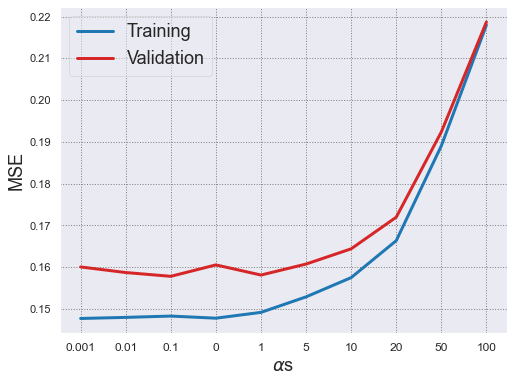

In [136]:
alphas = [0.001, 0.01, 0.1, 0, 1, 5, 10, 20, 50, 100]
loss_trns = []
loss_vals = []
for alpha in alphas:
    # instantiate a ridge regression model with a given alpha
    model = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    # TODO: training the model and get the training and validation loss for each alpha
    # train model?
    model.fit(X_trn, Y_trn)
    # loss_trns.append(?)
    loss_trns.append(mse(model.predict(X_trn), Y_trn))
    # loss_vals.append(?)
    loss_vals.append(mse(model.predict(X_val), Y_val))

fig, ax = plt.subplots(figsize=(8,6))
plt.grid(which='both',axis='both', color='grey',linestyle=':')

# TODO plot the training and validation loss below
plt.plot(np.arange(len(alphas)), loss_trns, label='Training', color='tab:blue', linewidth=3)
plt.plot(np.arange(len(alphas)), loss_vals, label='Validation', color='tab:red', linewidth=3)

# TODO how to plot the best validation loss?
# plt.plot(np.arange(len(alphas)), ?, color='tab:red', linestyle='--', linewidth=2)
# For example, if you want to hilight one horizontal line. 
#plt.plot(np.arange(len(alphas)), np.ones(len(alphas))*min(loss_vals), color='tab:red', linestyle='--', linewidth=2)# remove it when you finish the code

plt.ylabel('MSE', fontsize=18)
plt.xlabel(r'${\alpha}$s', fontsize=18)
plt.xticks(np.arange(len(alphas)), alphas, fontsize=12)
# TODO: add a legend
plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
plt.show()

### Q1-4: Compare your ridge regression model with Sklearn implmentation

In [149]:
# TODO: select alpha from Q1-3
alpha = 1
# Given w_r from Q1-2
# y_r_trn = ?
# y_r_val = ?
# y_r_tst = ?
# print the training/validation/testing MSE error by using the mse function

X_scatter = np.matmul(X_trn.T, X_trn) + alpha*np.identity(D)
w_r = np.matmul(np.matmul(np.linalg.inv(X_scatter), X_trn.T), Y_trn)
y_r_trn = np.matmul(X_trn, w_r)
y_r_val = np.matmul(X_val, w_r)
y_r_tst = np.matmul(X_tst, w_r)
print("Ridge regression: training err={:.3f}, validation err={:.3f}, testing err={:.3f}".format(mse(y_r_trn,Y_trn), mse(y_r_val,Y_val), mse(y_r_tst, Y_tst)))



# sklearn mdoel with the same alpha
model = linear_model.Ridge(alpha=alpha, fit_intercept=False)
model.fit(X_trn, Y_trn)
y_r_trn2 = model.predict(X_trn)
y_r_val2 = model.predict(X_val)
y_r_tst2 = model.predict(X_tst)
# print the training/validation/testing MSE error by using the mse function
print("Sklearn Ridge regression: training err={:.3f}, validation err={:.3f}, testing err={:.3f}".format(mse(y_r_trn2,Y_trn), mse(y_r_val2,Y_val), mse(y_r_tst2, Y_tst)))


Ridge regression: training err=0.149, validation err=0.158, testing err=0.165
Sklearn Ridge regression: training err=0.149, validation err=0.158, testing err=0.165


## Q2: K-means clustering
We will directly use the Sklearn libary for running K-means, spectral clustering, and hierarchical clustering. More details about the function usage could be referred to [Sklearn cluster](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) and this [tutorial](https://scikit-learn.org/stable/modules/clustering.html).

In [54]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

dataset = load_iris()
X = dataset.data
gnd = dataset.target
semantic_labels = dataset.target_names
print(semantic_labels)
print(gnd)
K = len(set(gnd)) # get the ground-truth cluster number

['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


### Q2-1: K-means (10 pts)
Given a K-means model, run it 20 times to report averaged NMI and std value. Save the clustering labels of each trial for the following steps.

In [208]:
import statistics
km = KMeans(n_clusters=K, init='random', n_init=1)
idx_km, nmis_km = [], []
for i in range(20):
    # run K-means here
    km.fit_predict(X)
    idx_km.append(km.labels_)
    nmis_km.append(nmi_score(gnd, km.labels_))
# report mean and std values of nmis
nmis_km=np.array(nmis_km)
print("Mean and Std values of nmis %s , %s"% (statistics.mean(nmis_km), statistics.stdev(nmis_km)))

Mean and Std values of nmis 0.7423169686433381 , 0.03736214829273752


### Q2-2: Compare K-means with SC and AC (10 pts)
Repeat Q2-1 with the following two given models.

In [150]:
sc = SpectralClustering(n_clusters=K, n_init=1) # spectral clustering model
ac = AgglomerativeClustering(n_clusters=K) # hierarchical clustering model
# TODO: repeat Q2-1 and compare km with sc and ac
idx_s, nmis_s = [], []
for i in range(20):
    # run soectral here
    sc.fit_predict(X)
    idx_s.append(sc.labels_)
    nmis_s.append(nmi_score(gnd, sc.labels_))
    
nmis_s=np.array(nmis_s)
print("MEAN and STD values of nmis from SPECTRAL: %s , %s"% (statistics.mean(nmis_s), statistics.stdev(nmis_s)))

idx_a, nmis_a = [], []
for i in range(20):
    # run soectral here
    ac.fit_predict(X)
    idx_a.append(ac.labels_)
    nmis_a.append(nmi_score(gnd, ac.labels_))
    
nmis_a=np.array(nmis_a)
print("MEAN and STD values of nmis from AGGLOMERATIVE: %s , %s"% (statistics.mean(nmis_a), statistics.stdev(nmis_a)))
print("MEAN and STD values of nmis from KMEANS: %s , %s"% (statistics.mean(nmis_km), statistics.stdev(nmis_km)))
print("Best results are obtained from Spectral clustering")
# print the comparion results

MEAN and STD values of nmis from SPECTRAL: 0.7979885217013319 , 0.0
MEAN and STD values of nmis from AGGLOMERATIVE: 0.770083661648787 , 0.0
MEAN and STD values of nmis from KMEANS: 0.7406905669609386 , 0.03696876335798229
Best results are obtained from Spectral clustering


### Q2-3: Plot K-means clustering results (20 pts)

In [209]:
bst_idx=idx[(np.where(nmis_km==max(nmis_km)))[0][0],:]
wst_idx=idx[(np.where(nmis_km==min(nmis_km)))[0][0],:]
clustering_labels=set(bst_idx)


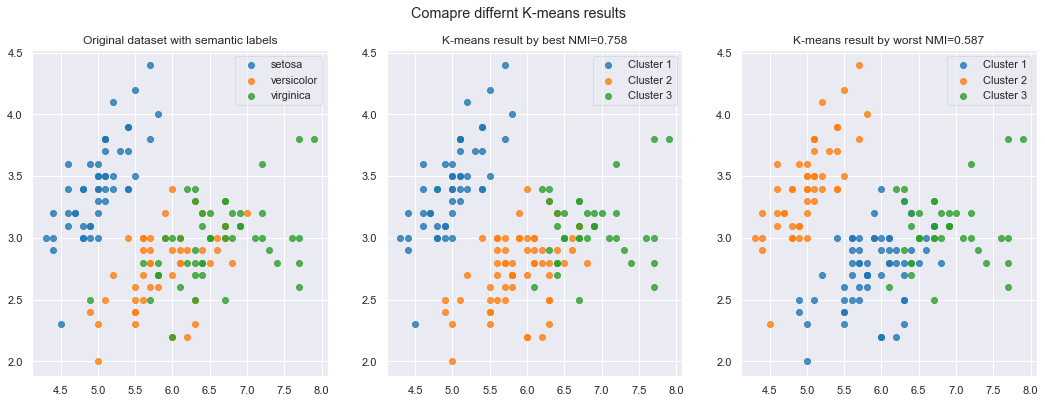

In [210]:
import seaborn as sns
sns.set_theme()

clustering_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']

# TODO: 
# 1) find the best/worst clustering labels by NMI, termed as bst_idx and wst_idx
# 2) scatter plot the data samples upon the clustering labels, bst_idx and wst_idx.

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Comapre differnt K-means results')
colors = ['tab:blue', 'tab:orange', 'tab:green']
ax1.set_title('Original dataset with semantic labels')
# fill out the NMI values in the title

ax2.set_title('K-means result by best NMI=0.758')
ax3.set_title('K-means result by worst NMI=0.587')

for color, i in zip(colors, [0, 1, 2]):
    ax1.scatter(X[gnd == i, 0], X[gnd == i, 1], color=color, alpha=.8, label=semantic_labels[i])
    ax2.scatter(X[bst_idx == i, 0], X[bst_idx == i, 1], color=color, alpha=.8, label=clustering_labels[i])
    ax3.scatter(X[wst_idx == i, 0], X[wst_idx == i, 1], color=color, alpha=.8, label=clustering_labels[i])
ax1.legend(fancybox=True, framealpha=0.5)

# TODO: add legends for ax2 and ax3
ax2.legend(fancybox=True, framealpha=0.5)
ax3.legend(fancybox=True, framealpha=0.5)

Answer the following questions:
- Can we use the semantic_labels for the clustering results plot? Why? 
- Why does the same clustering label (e.g., clustering 1) have different groups of samples between two K-means results?

Please directly answer the above question with Markdown inside this notebook file.

1) No we cannot directly use semantic_labels for the clustering results plot. With clustering, there's no meaningful order or comparison between clusters, we're just finding groups of observations that have something in common. As a result, the numbering used in the predicted labels from clustering algorithm could be different from the numbering of the ground truth labels. For example, looking at the 1st and the 3rd plots above we see that the model has accurately predicted the clusters in plot3 but the clusters are mislabelled. (orange cluster has different set of samples in plot1 vs plot3). In this case, the numbering doesn't match the numbering that was used in the ground truth, so the colors don't match up when we look at the generated clusters with the ground truth. So we will have to reassign the predicted cluster numbers using np.choose and then we can use the semantic labels. 


2) This happens because the ordering of the cluster labels is dependent on the initialization. Cluster 0 from the first run could be labeled cluster 1 in the second run and vice versa. This doesnt affect clustering evaluation metrics. The way to avoid this is to set the random seed to a fixed number, so that the behaviour of the algorithm is deterministic.  